## test
test changes in the répartition of the tiertiles when considering the krill biomass density or the krill biomass per cell.


In [2]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import os

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


### load data

In [22]:
xr.open_dataset('Krill_biomass_final.nc')

<xarray.Dataset>
Dimensions:             (time: 1, latitude: 20, longitude: 180)
Coordinates:
  * time                (time) datetime64[ns] 2010-12-29T12:00:00
  * latitude            (latitude) int32 -79 -77 -75 -73 -71 ... -47 -45 -43 -41
  * longitude           (longitude) int32 -179 -177 -175 -173 ... 175 177 179
Data variables:
    krill_young_larvae  (time, latitude, longitude) float64 ...
    krill_free_larvae   (time, latitude, longitude) float64 ...
    krill_late_larvae   (time, latitude, longitude) float64 ...
    krill_juveniles     (time, latitude, longitude) float64 ...
    krill_adults        (time, latitude, longitude) float64 ...
    krill_adult_log     (time, latitude, longitude) float64 ...
Attributes: (12/14)
    Conventions:                   CF-1.7
    comment:                       sample
    domain:                        antartica
    institution:                   CLS
    net_primary_production_model:  
    references:                    http://www.cls.fr; http://www.seapodym.eu
    ...                            ...
    source_forage_variables:       
    source_geochemical_variables:  
    source_physical_variables:     
    title:                         KRILLPODYM
    Created:                       2023-04-01
    date_field:                    20101229

In [23]:
# load data
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data/')

krill_pop = xr.open_dataset('Krill_biomass_final.nc')[['krill_adult_log', 'krill_adults']]
mean_time_seq = xr.open_dataset('xr_mean_time_seq_final.nc')
catch = xr.open_dataset('Krill_catch_array_final_all.nc')

In [24]:
mean_time_seq = mean_time_seq.rename_vars({'__xarray_dataarray_variable__' : 'mean_seq_time' })
catch = catch.rename_vars({'__xarray_dataarray_variable__' : 'krill_greenweight_kg_log' })

In [25]:
# transform into dataframe
krill_pop = krill_pop.to_dataframe().reset_index().drop(['time'], axis =1) # 3600 rows × 3 columns
mean_time_seq = mean_time_seq.to_dataframe().reset_index().drop(['variable'], axis =1) # 3240 rows × 3 columns
catch = catch.to_dataframe().reset_index().drop(['variable'], axis =1) # 1800 rows × 3 columns

### Krill biomass density per cell

In [26]:
# checks for krill pop
krill_pop = krill_pop.dropna()[krill_pop['krill_adult_log'] != 0]
krill_pop.set_index(['latitude', 'longitude'], inplace = True) #1815  rows × 3 columns
krill_pop

C:\Users\anael\AppData\Local\Temp\ipykernel_37032\1392448703.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  krill_pop = krill_pop.dropna()[krill_pop['krill_adult_log'] != 0]


krill_adult_log  krill_adults
latitude longitude                               
-75      -179               0.92934      7.498493
         -177               1.70806     50.058116
         -175               1.24843     16.718529
         -173               1.46391     28.100861
         -171               1.66276     45.000530
...                             ...           ...
-47       69                0.35615      1.270653
          71                0.01810      0.042562
-45       51                0.00947      0.022051
          53                0.03058      0.072949
          67                0.00009      0.000197

[1648 rows x 2 columns]

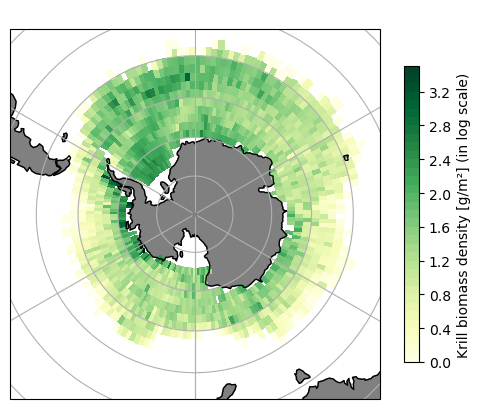

In [27]:
krill_array = xr.Dataset.from_dataframe(krill_pop.drop("krill_adults", axis = 1)) # convert into xarrayDataset
krill_array = xr.Dataset.to_array(krill_array)

### KRILL POPULATION 
map_proj = ccrs.SouthPolarStereo()

p = krill_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlGn"
) 


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill biomass density [g/m²] (in log scale)', shrink = 0.8, boundaries = np.linspace(0,3.5,36))
plt.title(' ')
plt.show(p)

### Krill biomass per cell

import the areas of cells

In [28]:
# selct the formated file
OCIM = xr.open_dataset('fseq_OCIM2_48L_interpolated_SO.nc')
OCIM 

<xarray.Dataset>
Dimensions:        (ocean grid point: 405386, time: 1001, latitude: 20,
                    longitude: 180, depth: 48)
Coordinates:
  * longitude      (longitude) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * depth          (depth) float64 4.935 14.88 25.12 ... 5.253e+03 5.582e+03
  * latitude       (latitude) int32 -79 -77 -75 -73 -71 ... -49 -47 -45 -43 -41
Dimensions without coordinates: ocean grid point, time
Data variables:
    fseq           (ocean grid point, time) float64 ...
    MASK           (latitude, longitude, depth) float64 ...
    LAT            (latitude, longitude, depth) float64 ...
    LON            (latitude, longitude, depth) float64 ...
    DEPTH          (latitude, longitude, depth) float64 ...
    VOL            (latitude, longitude, depth) float64 ...
    AREA           (latitude, longitude, depth) float64 ...
    mean_seq_time  (latitude, longitude, depth) float64 ...

In [29]:
# transform area array into a dataframe and crop the file à -45°S
area_df = OCIM[['AREA', 'MASK']].isel(depth=0).to_dataframe().drop(['depth'], axis = 1).reset_index()
area_df = area_df[area_df['latitude'] <=-45].set_index(['latitude', 'longitude'])
area_df['True_area'] = area_df['AREA']*area_df['MASK']
area_df # 3240 rows

AREA      MASK     True_area
latitude longitude                                      
-79      -179.0     9.332850e+09  0.061111  5.703408e+08
         -177.0     9.332850e+09  0.061111  5.703408e+08
         -175.0     9.332850e+09  0.061111  5.703408e+08
         -173.0     9.332850e+09  0.061111  5.703408e+08
         -171.0     9.332850e+09  0.061111  5.703408e+08
...                          ...       ...           ...
-45       171.0     3.458337e+10  0.750000  2.593752e+10
          173.0     3.458337e+10  1.000000  3.458337e+10
          175.0     3.458337e+10  1.000000  3.458337e+10
          177.0     3.458337e+10  1.000000  3.458337e+10
          179.0     3.458337e+10  1.000000  3.458337e+10

[3240 rows x 3 columns]

In [34]:
# join the area to the krill pop data
krill_pop_biomass = krill_pop.join(other = area_df, how='left')
krill_pop_biomass['krill_adult_biomass'] = krill_pop_biomass['krill_adults']*krill_pop_biomass['True_area'] # in gramms of krill per cell
krill_pop_biomass

krill_adult_log  krill_adults          AREA  MASK  \
latitude longitude                                                      
-75      -179               0.92934      7.498493  1.265922e+10   1.0   
         -177               1.70806     50.058116  1.265922e+10   1.0   
         -175               1.24843     16.718529  1.265922e+10   1.0   
         -173               1.46391     28.100861  1.265922e+10   1.0   
         -171               1.66276     45.000530  1.265922e+10   1.0   
...                             ...           ...           ...   ...   
-47       69                0.35615      1.270653  3.335547e+10   1.0   
          71                0.01810      0.042562  3.335547e+10   1.0   
-45       51                0.00947      0.022051  3.458337e+10   1.0   
          53                0.03058      0.072949  3.458337e+10   1.0   
          67                0.00009      0.000197  3.458337e+10   1.0   

                       True_area  krill_adult_biomass  
latitude longitude                                     
-75      -179       1.265922e+10         9.492504e+10  
         -177       1.265922e+10         6.336965e+11  
         -175       1.265922e+10         2.116435e+11  
         -173       1.265922e+10         3.557349e+11  
         -171       1.265922e+10         5.696714e+11  
...                          ...                  ...  
-47       69        3.335547e+10         4.238323e+10  
          71        3.335547e+10         1.419676e+09  
-45       51        3.458337e+10         7.626135e+08  
          53        3.458337e+10         2.522811e+09  
          67        3.458337e+10         6.823869e+06  

[1648 rows x 6 columns]

In [43]:
# we log the data to have a more readable visualization
def my_log(x):
    return np.round(np.log10(x+1), 5)

krill_pop_biomass = krill_pop_biomass.assign(krill_adult_biomass_log = my_log(krill_pop_biomass['krill_adult_biomass']))
krill_pop_biomass

krill_adult_log  krill_adults          AREA  MASK  \
latitude longitude                                                      
-75      -179               0.92934      7.498493  1.265922e+10   1.0   
         -177               1.70806     50.058116  1.265922e+10   1.0   
         -175               1.24843     16.718529  1.265922e+10   1.0   
         -173               1.46391     28.100861  1.265922e+10   1.0   
         -171               1.66276     45.000530  1.265922e+10   1.0   
...                             ...           ...           ...   ...   
-47       69                0.35615      1.270653  3.335547e+10   1.0   
          71                0.01810      0.042562  3.335547e+10   1.0   
-45       51                0.00947      0.022051  3.458337e+10   1.0   
          53                0.03058      0.072949  3.458337e+10   1.0   
          67                0.00009      0.000197  3.458337e+10   1.0   

                       True_area  krill_adult_biomass  krill_adult_biomass_log  
latitude longitude                                                              
-75      -179       1.265922e+10         9.492504e+10                 10.97738  
         -177       1.265922e+10         6.336965e+11                 11.80188  
         -175       1.265922e+10         2.116435e+11                 11.32560  
         -173       1.265922e+10         3.557349e+11                 11.55113  
         -171       1.265922e+10         5.696714e+11                 11.75562  
...                          ...                  ...                      ...  
-47       69        3.335547e+10         4.238323e+10                 10.62719  
          71        3.335547e+10         1.419676e+09                  9.15219  
-45       51        3.458337e+10         7.626135e+08                  8.88230  
          53        3.458337e+10         2.522811e+09                  9.40188  
          67        3.458337e+10         6.823869e+06                  6.83403  

[1648 rows x 7 columns]

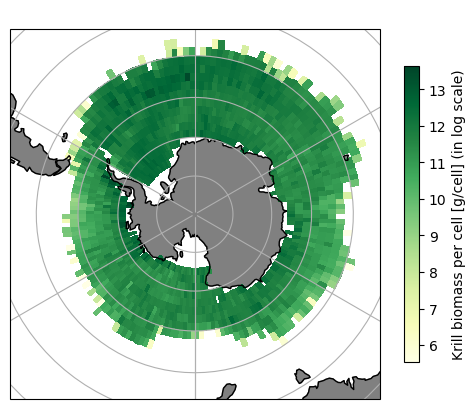

In [45]:
krill_biomass_array = xr.Dataset.from_dataframe(krill_pop_biomass[['krill_adult_biomass_log']]) # convert into xarrayDataset
krill_biomass_array = xr.Dataset.to_array(krill_biomass_array)

### KRILL POPULATION 
map_proj = ccrs.SouthPolarStereo()

p = krill_biomass_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlGn"
) 


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill biomass per cell [g/cell] (in log scale)', shrink = 0.8)
plt.title(' ')
plt.show(p)

## Compare the spatial distrib of tier-tiles

Select the upper tier-tile of the data (each version) and plot it.

In [53]:
krill_quantile_biomass = krill_pop_biomass['krill_adult_biomass_log'].quantile(q=[0.3333, 0.6666]) 
krill_quantile_biomass

0.3333    11.366415
0.6666    11.851630
Name: krill_adult_biomass_log, dtype: float64

In [54]:
krill_pop_biomass_tier_sup = krill_pop_biomass.loc[(krill_pop_biomass['krill_adult_biomass_log'] > float(krill_quantile_biomass.iloc[1]))]
krill_pop_biomass_tier_sup # 550

krill_adult_log  krill_adults          AREA  MASK  \
latitude longitude                                                      
-75      -159               2.13612    135.811375  1.265922e+10   1.0   
         -153               2.85153    709.450623  1.265922e+10   1.0   
         -149               1.84309     68.677155  1.265922e+10   1.0   
         -147               1.82552     65.914055  1.265922e+10   1.0   
         -145               2.54457    349.404907  1.265922e+10   1.0   
...                             ...           ...           ...   ...   
-51       33                1.71165     50.480835  3.077929e+10   1.0   
          35                1.50614     31.073215  3.077929e+10   1.0   
          53                1.40682     24.516615  3.077929e+10   1.0   
-49       9                 1.53130     32.985622  3.208693e+10   1.0   
          25                1.45804     27.710205  3.208693e+10   1.0   

                       True_area  krill_adult_biomass  krill_adult_biomass_log  
latitude longitude                                                              
-75      -159       1.265922e+10         1.719266e+12                 12.23534  
         -153       1.265922e+10         8.981089e+12                 12.95333  
         -149       1.265922e+10         8.693989e+11                 11.93922  
         -147       1.265922e+10         8.344203e+11                 11.92138  
         -145       1.265922e+10         4.423192e+12                 12.64574  
...                          ...                  ...                      ...  
-51       33        3.077929e+10         1.553764e+12                 12.19139  
          35        3.077929e+10         9.564115e+11                 11.98064  
          53        3.077929e+10         7.546040e+11                 11.87772  
-49       9         3.208693e+10         1.058407e+12                 12.02465  
          25        3.208693e+10         8.891353e+11                 11.94897  

[550 rows x 7 columns]

In [55]:
krill_quantile = krill_pop['krill_adult_log'].quantile(q=[0.3333, 0.6666]) 
krill_quantile

0.3333    1.049312
0.6666    1.522825
Name: krill_adult_log, dtype: float64

In [56]:
krill_pop_tier_sup = krill_pop.loc[(krill_pop['krill_adult_log'] > float(krill_quantile.iloc[1]))]
krill_pop_tier_sup # 550

krill_adult_log  krill_adults
latitude longitude                               
-75      -177               1.70806     50.058116
         -171               1.66276     45.000530
         -165               1.74653     54.786858
         -163               1.57327     36.434536
         -159               2.13612    135.811375
...                             ...           ...
-51       27                2.12996    133.882904
          29                1.56268     35.532314
          31                1.53461     33.246071
          33                1.71165     50.480835
-49       9                 1.53130     32.985622

[550 rows x 2 columns]

#### make regular grid

In [59]:
# make dataset with coordinates
coords = pd.DataFrame({'latitude':np.repeat(np.arange(-75, -45, 2), 180), # -75 to -51
                       'longitude': np.tile(np.arange(-179, 180, 2), 15), # -179 to 179
                       'label_grid': np.zeros(2700)}).set_index(['latitude', 'longitude'])

coords = coords.sort_values(['latitude', 'longitude'])
coords # 2700 rows

label_grid
latitude longitude            
-75      -179              0.0
         -177              0.0
         -175              0.0
         -173              0.0
         -171              0.0
...                        ...
-47       171              0.0
          173              0.0
          175              0.0
          177              0.0
          179              0.0

[2700 rows x 1 columns]

In [60]:
krill_pop_biomass_tier_sup_complete = coords.join(krill_pop_biomass_tier_sup, how='left')
krill_pop_tier_sup_complete = coords.join(krill_pop_tier_sup, how='left')

### plot

In [61]:
## plot both to compare
# transform in xarray

krill_array_tier_sup = xr.Dataset.from_dataframe(krill_pop_tier_sup_complete[['krill_adult_log']]) # convert into xarrayDataset
krill_array_tier_sup = xr.Dataset.to_array(krill_array_tier_sup)

krill_biomass_array_tier_sup = xr.Dataset.from_dataframe(krill_pop_biomass_tier_sup_complete[['krill_adult_biomass_log']]) # convert into xarrayDataset
krill_biomass_array_tier_sup = xr.Dataset.to_array(krill_biomass_array_tier_sup)

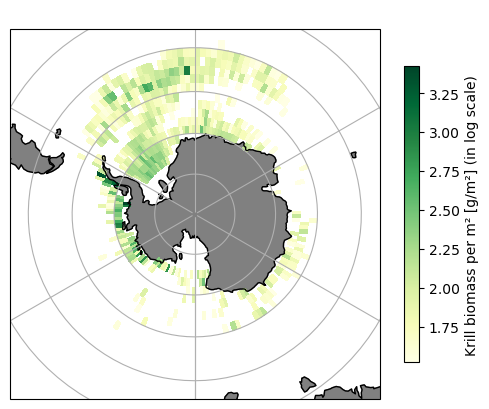

In [63]:
# version density
map_proj = ccrs.SouthPolarStereo()

p = krill_array_tier_sup.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlGn",
    #color = 'orange'
) 


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill biomass per m² [g/m²] (in log scale)', shrink = 0.8)
plt.title(' ')
plt.show(p)

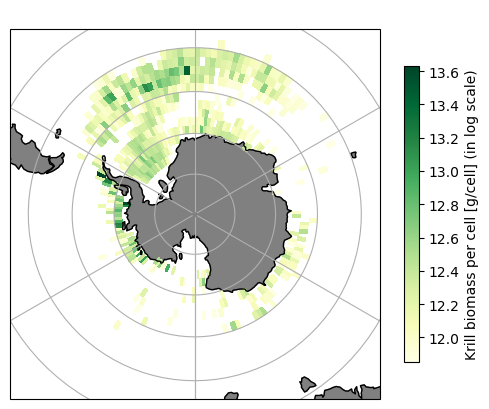

In [64]:
# version per cell

map_proj = ccrs.SouthPolarStereo()

p = krill_biomass_array_tier_sup.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlGn",
    #color = 'orange'
) 


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill biomass per cell [g/cell] (in log scale)', shrink = 0.8)
plt.title(' ')
plt.show(p)

### compare the two df to see the differences 
Differences are not visible on the plot, check in details the dfs.

In [73]:
# outer join the two df to compare where are the differences
krill_tier_sup_comp = krill_pop_biomass_tier_sup[['krill_adult_biomass_log']].join(other = krill_pop_tier_sup[['krill_adult_log']], how='outer')#, lsuffix='_B', rsuffix='_D')
krill_tier_sup_comp # 578 => 28 rows different

krill_adult_biomass_log  krill_adult_log
latitude longitude                                          
-75      -177                           NaN          1.70806
         -171                           NaN          1.66276
         -165                           NaN          1.74653
         -163                           NaN          1.57327
         -159                      12.23534          2.13612
...                                     ...              ...
-51       33                       12.19139          1.71165
          35                       11.98064              NaN
          53                       11.87772              NaN
-49       9                        12.02465          1.53130
          25                       11.94897              NaN

[578 rows x 2 columns]

In [87]:
diff = krill_tier_sup_comp[krill_tier_sup_comp['krill_adult_biomass_log'].isna() | krill_tier_sup_comp['krill_adult_log'].isna()]
diff['D'] = np.where(diff['krill_adult_biomass_log'].isna(), 1, 2)
diff # 56 rows (= 28 *2)

C:\Users\anael\AppData\Local\Temp\ipykernel_37032\2003136552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff['D'] = np.where(diff['krill_adult_biomass_log'].isna(), 1, 2)


krill_adult_biomass_log  krill_adult_log  D
latitude longitude                                             
-75      -177                           NaN          1.70806  1
         -171                           NaN          1.66276  1
         -165                           NaN          1.74653  1
         -163                           NaN          1.57327  1
         -157                           NaN          1.58161  1
         -151                           NaN          1.71720  1
          169                           NaN          1.59838  1
          175                           NaN          1.71869  1
-73      -175                           NaN          1.61069  1
         -173                           NaN          1.63985  1
         -167                           NaN          1.60075  1
         -135                           NaN          1.60055  1
-71      -175                           NaN          1.56047  1
         -115                           NaN          1.63069  1
          171                           NaN          1.59694  1
          175                           NaN          1.54356  1
-69      -85                            NaN          1.59406  1
         -83                            NaN          1.55829  1
          167                           NaN          1.54005  1
-67      -73                            NaN          1.53606  1
         -51                            NaN          1.54169  1
          13                            NaN          1.57469  1
          23                            NaN          1.56888  1
-65      -13                            NaN          1.52744  1
         -1                             NaN          1.54224  1
          29                            NaN          1.54818  1
          39                            NaN          1.53151  1
          93                            NaN          1.53710  1
-59      -49                       11.87210              NaN  2
          7                        11.85793              NaN  2
          21                       11.87610              NaN  2
          27                       11.86134              NaN  2
          37                       11.86503              NaN  2
-57       15                       11.91454              NaN  2
          17                       11.91505              NaN  2
          31                       11.88646              NaN  2
          71                       11.90532              NaN  2
-55      -47                       11.94557              NaN  2
         -33                       11.94515              NaN  2
         -31                       11.92814              NaN  2
          41                       11.91058              NaN  2
          43                       11.94985              NaN  2
-53       21                       11.89556              NaN  2
          33                       11.90523              NaN  2
          37                       11.90519              NaN  2
          41                       11.85170              NaN  2
          43                       11.95569              NaN  2
          45                       11.89761              NaN  2
          63                       11.85742              NaN  2
-51      -37                       11.89174              NaN  2
         -35                       11.95554              NaN  2
         -31                       11.88957              NaN  2
         -19                       11.88432              NaN  2
          35                       11.98064              NaN  2
          53                       11.87772              NaN  2
-49       25                       11.94897              NaN  2

In [88]:
diff = coords.join(other = diff, how='left')
diff

label_grid  krill_adult_biomass_log  krill_adult_log    D
latitude longitude                                                           
-75      -179              0.0                      NaN              NaN  NaN
         -177              0.0                      NaN          1.70806  1.0
         -175              0.0                      NaN              NaN  NaN
         -173              0.0                      NaN              NaN  NaN
         -171              0.0                      NaN          1.66276  1.0
...                        ...                      ...              ...  ...
-47       171              0.0                      NaN              NaN  NaN
          173              0.0                      NaN              NaN  NaN
          175              0.0                      NaN              NaN  NaN
          177              0.0                      NaN              NaN  NaN
          179              0.0                      NaN              NaN  NaN

[2700 rows x 4 columns]

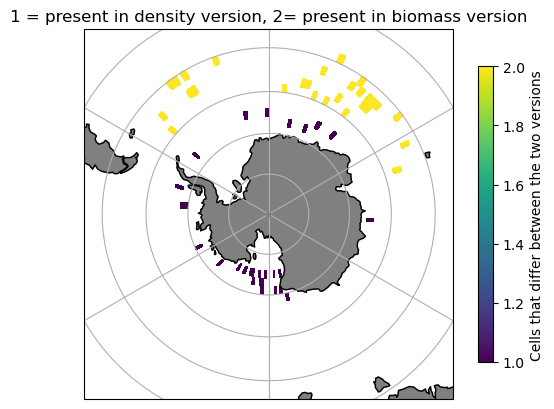

In [93]:
diff_array = xr.Dataset.from_dataframe(diff[['D']]) # convert into xarrayDataset
diff_array = xr.Dataset.to_array(diff_array)

map_proj = ccrs.SouthPolarStereo()

p = diff_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap= "YlGn",
    #color = 'orange'
) 


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Cells that differ between the two versions', shrink = 0.8)
plt.title('1 = present in density version, 2= present in biomass version')
plt.show(p)

# Impact on the categories

In [97]:
# merge the other components
data_biomass = pd.merge(mean_time_seq, krill_pop_biomass[['krill_adult_biomass_log']], on = ['latitude', 'longitude'], how='inner')
data_biomass.set_index(['latitude', 'longitude'], inplace = True)

In [100]:
data_biomass

mean_seq_time  krill_adult_biomass_log
latitude longitude                                        
-75      -179          646.910548                 10.97738
         -177          601.882341                 11.80188
         -175          655.238074                 11.32560
         -173          641.075711                 11.55113
         -171          620.753036                 11.75562
...                           ...                      ...
-47       69            44.367955                 10.62719
          71            88.203798                  9.15219
-45       51           306.736232                  8.88230
          53           340.716198                  9.40188
          67           238.034583                  6.83403

[1648 rows x 2 columns]

In [111]:
seq_quantile = mean_time_seq.set_index(['latitude', 'longitude']).quantile(q=[0.3333, 0.6666]) # 311.399158 ; 435.064221

# upper right = the KAKS  : high krill and high carbon seq efficiency
UR_data_biomass = data_biomass.loc[(data_biomass['krill_adult_biomass_log'] > float(krill_quantile_biomass.iloc[1])) & (data_biomass['mean_seq_time'] > float(seq_quantile.iloc[1]))]
# add a column with label
UR_data_biomass['label'] = 3

# The lower right part = the areas with high krill population but low or medium carbon seq efficiency
LR_data_biomass = data_biomass.loc[(data_biomass['krill_adult_biomass_log'] > float(krill_quantile_biomass.iloc[1])) & (data_biomass['mean_seq_time'] < float(seq_quantile.iloc[1]))]
# add a column with label
LR_data_biomass['label'] = 2

# the upper left categorie = The area of high carbon seq efficiency but low or medium krill density
UL_data_biomass = data_biomass.loc[(data_biomass['krill_adult_biomass_log'] < float(krill_quantile_biomass.iloc[1])) & (data_biomass['mean_seq_time'] > float(seq_quantile.iloc[1]))]
#UL_data = data.loc[(data['krill_adult_log'] < float(krill_quantile.iloc[0])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
# add a column with label
UL_data_biomass['label'] = 1

C:\Users\anael\AppData\Local\Temp\ipykernel_37032\1615731060.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  UR_data_biomass = data_biomass.loc[(data_biomass['krill_adult_biomass_log'] > float(krill_quantile_biomass.iloc[1])) & (data_biomass['mean_seq_time'] > float(seq_quantile.iloc[1]))]
C:\Users\anael\AppData\Local\Temp\ipykernel_37032\1615731060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UR_data_biomass['label'] = 3
C:\Users\anael\AppData\Local\Temp\ipykernel_37032\1615731060.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  LR_data_

In [112]:
## Concatenate the three dataframe together
zones_data_biomass = pd.concat([UR_data_biomass, LR_data_biomass, UL_data_biomass])
zones_data_biomass #960  rows

mean_seq_time  krill_adult_biomass_log  label
latitude longitude                                               
-75      -159          440.483941                 12.23534      3
         -147          446.233208                 11.92138      3
         -57           799.030550                 12.25427      3
         -55           782.741218                 12.32981      3
         -53           771.921695                 12.40780      3
...                           ...                      ...    ...
-55       9            600.485983                 11.82939      1
          23           574.973871                 11.72667      1
          83           441.143236                 10.34047      1
          105          435.488304                 10.80031      1
-53       3            467.553699                 11.81034      1

[969 rows x 3 columns]

In [113]:
data_labeled_biomass = data_biomass.join(zones_data_biomass.drop(['mean_seq_time', 'krill_adult_biomass_log'], axis = 1)).fillna(0)
data_labeled_biomass # 1648

mean_seq_time  krill_adult_biomass_log  label
latitude longitude                                               
-75      -179          646.910548                 10.97738    1.0
         -177          601.882341                 11.80188    1.0
         -175          655.238074                 11.32560    1.0
         -173          641.075711                 11.55113    1.0
         -171          620.753036                 11.75562    1.0
...                           ...                      ...    ...
-47       69            44.367955                 10.62719    0.0
          71            88.203798                  9.15219    0.0
-45       51           306.736232                  8.88230    0.0
          53           340.716198                  9.40188    0.0
          67           238.034583                  6.83403    0.0

[1648 rows x 3 columns]

In [114]:
zones_data_biomass_complete = coords.join(data_labeled_biomass, how='left')
zones_data_biomass_complete#.dropna().shape # 2700  rows, 603 non-nan rows

label_grid  mean_seq_time  krill_adult_biomass_log  label
latitude longitude                                                           
-75      -179              0.0     646.910548                 10.97738    1.0
         -177              0.0     601.882341                 11.80188    1.0
         -175              0.0     655.238074                 11.32560    1.0
         -173              0.0     641.075711                 11.55113    1.0
         -171              0.0     620.753036                 11.75562    1.0
...                        ...            ...                      ...    ...
-47       171              0.0            NaN                      NaN    NaN
          173              0.0            NaN                      NaN    NaN
          175              0.0            NaN                      NaN    NaN
          177              0.0            NaN                      NaN    NaN
          179              0.0            NaN                      NaN    NaN

[2700 rows x 4 columns]

# Compare with the categories calculated with density data


In [118]:
# load the other zones file 
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/output_results/')
array_krill_carbon = xr.open_dataset('zones_krill_carbon.nc').to_array()
zones_krill_carbon = pd.read_csv('zones_krill_carbon.csv').set_index(['latitude', 'longitude'])
zones_krill_carbon

label_grid  mean_seq_time  krill_adult_log  \
latitude longitude                                               
-75      -179              0.0     646.910548          0.92934   
         -177              0.0     601.882341          1.70806   
         -175              0.0     655.238074          1.24843   
         -173              0.0     641.075711          1.46391   
         -171              0.0     620.753036          1.66276   
...                        ...            ...              ...   
-47       171              0.0            NaN              NaN   
          173              0.0            NaN              NaN   
          175              0.0            NaN              NaN   
          177              0.0            NaN              NaN   
          179              0.0            NaN              NaN   

                    krill_catch_density_log  label  
latitude longitude                                  
-75      -179                           0.0    1.0  
         -177                           0.0    3.0  
         -175                           0.0    1.0  
         -173                           0.0    1.0  
         -171                           0.0    3.0  
...                                     ...    ...  
-47       171                           NaN    NaN  
          173                           NaN    NaN  
          175                           NaN    NaN  
          177                           NaN    NaN  
          179                           NaN    NaN  

[2700 rows x 5 columns]

#### Made with density

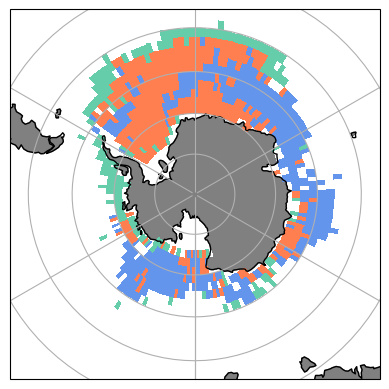

In [117]:
map_proj = ccrs.SouthPolarStereo()

p = array_krill_carbon.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj}, # the plot's projection
    levels=[1, 2, 3, 4], 
    colors = ['white', 'cornflowerblue', 'mediumaquamarine', 'coral']
)  


### Add features:
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
plt.title('')

# save
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#plt.savefig('p_overlap_krill_carbon.png')

plt.show(p)

#### Made with biomass per cell

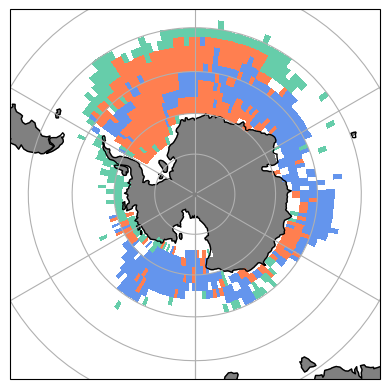

In [115]:
zones_array_biomass = xr.Dataset.from_dataframe(zones_data_biomass_complete.drop(['krill_adult_biomass_log', 'mean_seq_time', 'label_grid'], axis = 1)) # convert into xarrayDataset
zones_array_biomass = xr.Dataset.to_array(zones_array_biomass)

map_proj = ccrs.SouthPolarStereo()

p = zones_array_biomass.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj}, # the plot's projection
    levels=[1, 2, 3, 4], 
    colors = ['white', 'cornflowerblue', 'mediumaquamarine', 'coral']
)  


### Add features:
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
plt.title('')

# save
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#plt.savefig('p_overlap_krill_carbon.png')

plt.show(p)

### Make the difference between the two version

In [119]:
zones_krill_carbon.dropna()[['label']]

label
latitude longitude       
-75      -179         1.0
         -177         3.0
         -175         1.0
         -173         1.0
         -171         3.0
...                   ...
-47       63          0.0
          65          0.0
          67          0.0
          69          0.0
          71          0.0

[1644 rows x 1 columns]

In [121]:
zones_data_biomass_complete.dropna()[['label']]

label
latitude longitude       
-75      -179         1.0
         -177         1.0
         -175         1.0
         -173         1.0
         -171         1.0
...                   ...
-47       63          0.0
          65          0.0
          67          0.0
          69          0.0
          71          0.0

[1645 rows x 1 columns]

In [133]:
diff = zones_krill_carbon.dropna()[['label']].join(other = zones_data_biomass_complete.dropna()[['label']], how = 'outer', rsuffix ='_biomass')
diff['D'] = np.where(diff['label'] == diff['label_biomass'], 0, 1)
diff = coords.join(other = diff, how='left').dropna()

In [132]:
diff.dropna()

label_grid  label  label_biomass    D
latitude longitude                                       
-75      -179              0.0    1.0            1.0  0.0
         -177              0.0    3.0            1.0  1.0
         -175              0.0    1.0            1.0  0.0
         -173              0.0    1.0            1.0  0.0
         -171              0.0    3.0            1.0  1.0
...                        ...    ...            ...  ...
-47       63               0.0    0.0            0.0  0.0
          65               0.0    0.0            0.0  0.0
          67               0.0    0.0            0.0  0.0
          69               0.0    0.0            0.0  0.0
          71               0.0    0.0            0.0  0.0

[1644 rows x 4 columns]

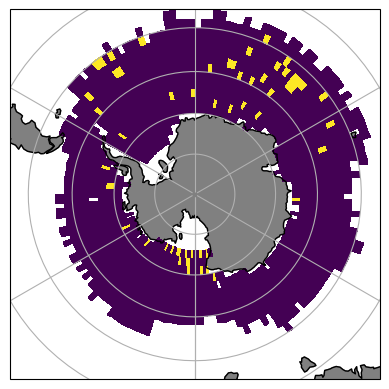

In [136]:
diff_array = xr.Dataset.from_dataframe(diff[['D']]) # convert into xarrayDataset
diff_array = xr.Dataset.to_array(diff_array)

map_proj = ccrs.SouthPolarStereo()

p = diff_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap= "YlGn",
    #color = 'orange'
) 


### Add features:
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
plt.title('')

# save
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#plt.savefig('p_overlap_krill_carbon.png')

plt.show(p)